In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 11179614.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 38177022.95it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 8415510.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 7108406.26it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Input: 28x28
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output: 7x7
            nn.ReLU(),
            nn.Flatten(),     # Flatten into a vector
            nn.Linear(32 * 7 * 7, 128), 
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 32 * 7 * 7),              
            nn.ReLU(),           
            nn.Unflatten(1, (32, 7, 7)),            # Reshape
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  
            nn.Tanh()  # Use Tanh to keep output between -1 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Conv2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[str, int, Tuple[int, int]] = 0, dilation: Union[int, Tuple[int, int]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros', device=None, dtype=None) -> None
 |  
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
 |  
 |  
 |  where :math:`\star` is the valid 2D `cross-correlation`_ operator,
 |  :math:`N

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):  # Adjust the number of epochs
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

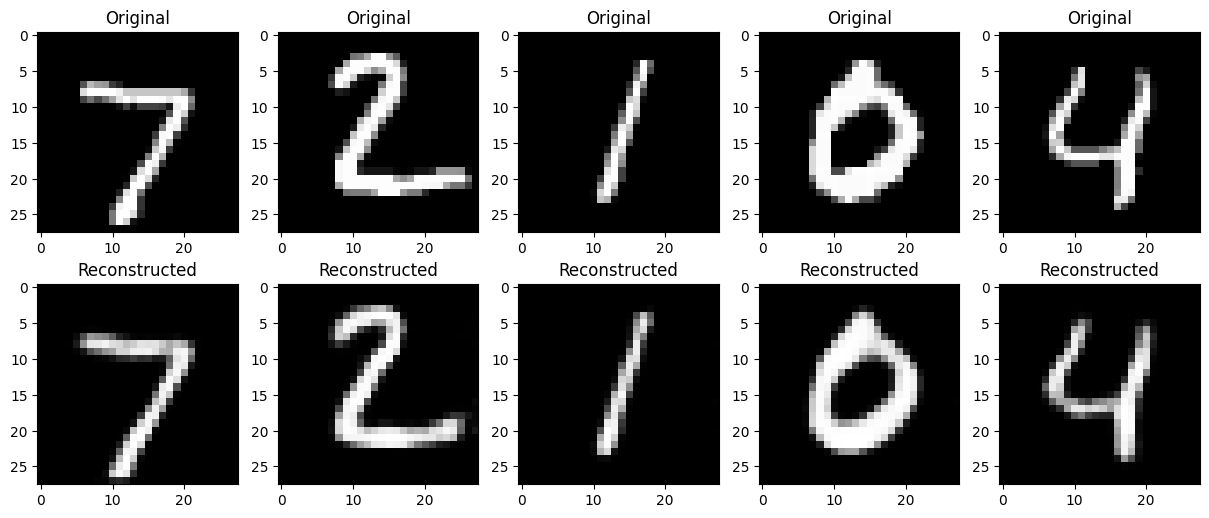

In [5]:
import matplotlib.pyplot as plt

# ... (after training) ...
with torch.no_grad():
    sample_images, _ = next(iter(test_loader))
    output = model(sample_images.to(device))
    # Plot original and reconstructed images side-by-side
    # Select some images to visualize (adjust the number if needed)
    images_to_show = 5 

    fig, axes = plt.subplots(nrows=2, ncols=images_to_show, figsize=(15, 6))

    # Plot original images
    for i in range(images_to_show):
        axes[0, i].imshow(sample_images[i].cpu().squeeze().numpy(), cmap='gray')
        axes[0, i].set_title('Original')

    # Plot reconstructed images
    for i in range(images_to_show):
        axes[1, i].imshow(output[i].cpu().squeeze().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')

    plt.show()

In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def add_noise(image):
    noise_factor = 0.5
    noisy_image = image + noise_factor * torch.randn_like(image)
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        noisy_image = add_noise(image)
        return image, noisy_image, label

    def __len__(self):
        return len(self.original_dataset)

# Dataset and loader setup
original_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
original_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=original_transform)

paired_dataset = PairedDataset(original_dataset)
train_loader = DataLoader(paired_dataset, batch_size=64, shuffle=True)

model = Autoencoder().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)

for epoch in range(10):  # Adjust the number of epochs
    # Modify the training loop to use noisy images as input
    for images, noisy_images, _ in train_loader:
        noisy_images = noisy_images.to(device)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # Target is the original image
        loss.backward()
        optimizer.step()
        
    print("Epoch: ", epoch, loss)

Epoch:  0 tensor(0.1397, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  1 tensor(0.0941, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  2 tensor(0.0643, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  3 tensor(0.0613, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  4 tensor(0.0586, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  5 tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  6 tensor(0.0386, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  7 tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  8 tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  9 tensor(0.0371, device='cuda:0', grad_fn=<MseLossBackward0>)


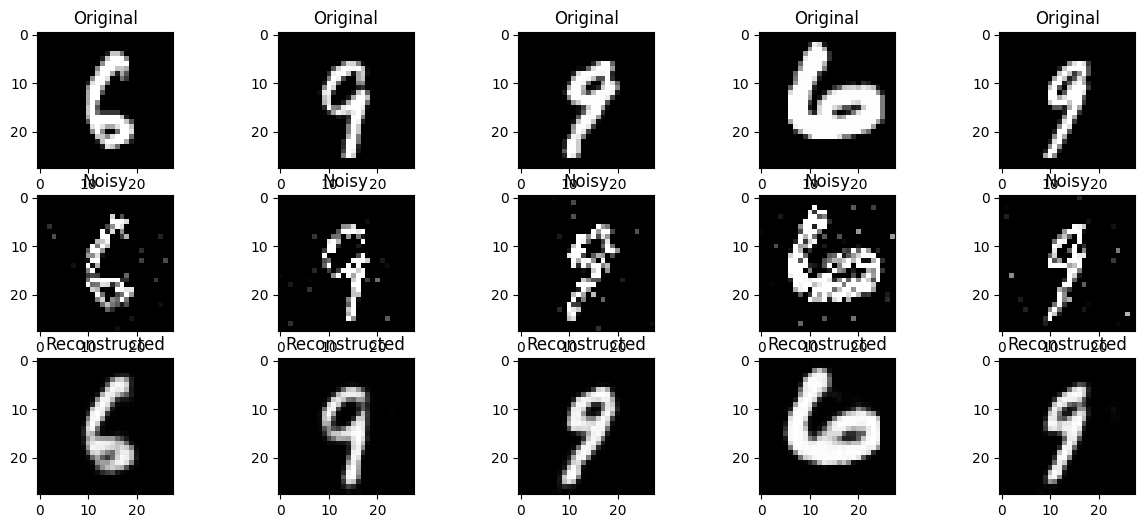

In [42]:
original_test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
original_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=original_transform)

paired_test_dataset = PairedDataset(original_test_dataset)
test_loader = DataLoader(paired_test_dataset, batch_size=64, shuffle=True)

import matplotlib.pyplot as plt

# ... (after training) ...
with torch.no_grad():
    images, noisy_images, _ = next(iter(test_loader))
    output = model(noisy_images.to(device))
    # Plot original and reconstructed images side-by-side
    # Select some images to visualize (adjust the number if needed)
    images_to_show = 5 

    fig, axes = plt.subplots(nrows=3, ncols=images_to_show, figsize=(15, 6))

    # Plot original images
    for i in range(images_to_show):
        axes[0, i].imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        
    # Plot reconstructed images
    for i in range(images_to_show):
        axes[1, i].imshow(noisy_images[i].cpu().squeeze().numpy(), cmap='gray')
        axes[1, i].set_title('Noisy')
        
    # Plot reconstructed images
    for i in range(images_to_show):
        axes[2, i].imshow(output[i].cpu().squeeze().numpy(), cmap='gray')
        axes[2, i].set_title('Reconstructed')

    plt.show()

In [25]:
image = images[0].cpu()

In [28]:
type(image)

torch.Tensor

In [29]:
help(image.squeeze)

Help on built-in function squeeze:

squeeze(...) method of torch.Tensor instance
    squeeze(dim=None) -> Tensor
    
    See :func:`torch.squeeze`



In [30]:
help(torch.squeeze)

Help on built-in function squeeze in module torch:

squeeze(...)
    squeeze(input, dim=None) -> Tensor
    
    Returns a tensor with all specified dimensions of :attr:`input` of size `1` removed.
    
    For example, if `input` is of shape:
    :math:`(A \times 1 \times B \times C \times 1 \times D)` then the `input.squeeze()`
    will be of shape: :math:`(A \times B \times C \times D)`.
    
    When :attr:`dim` is given, a squeeze operation is done only in the given
    dimension(s). If `input` is of shape: :math:`(A \times 1 \times B)`,
    ``squeeze(input, 0)`` leaves the tensor unchanged, but ``squeeze(input, 1)``
    will squeeze the tensor to the shape :math:`(A \times B)`.
    
    .. note:: The returned tensor shares the storage with the input tensor,
              so changing the contents of one will change the contents of the other.
    
    .. warning:: If the tensor has a batch dimension of size 1, then `squeeze(input)`
              will also remove the batch dimension

In [36]:
s = image.squeeze()
s.shape

torch.Size([28, 28])

In [37]:
s

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

In [38]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the Axes size
    and the *dpi* of the figure. This can lead to aliasing artifacts when
    the image is resampled because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled via the *interpolation* parameter
    and/or 

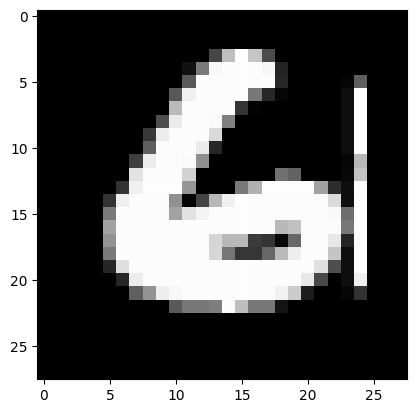

In [41]:
plt.imshow(s.numpy(), cmap='gray')